In [127]:
import turbo as tb
import rul_dataframe as rd
import plots as pl
import preprocessing as pre
import classification as cls

In [128]:
import numpy as np
import pandas as pd

In [129]:
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from gtda.plotting import plot_point_cloud
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
)

In [130]:
preproc = pre.Preprocessing()
classy = cls.Classification()

In [261]:
dataset = 3

In [262]:
scale = 'minmax'

In [263]:
tr, te, rl = tb.getTFDataset(set = dataset)
tb.addTFlinear(tr, te, rl)
tr_df = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
plots = pl.Plots(tr_df)
if dataset in [1,3]:
    preproc.drop_zero_variance(rul_df = tr_df)
    preproc.scale(rul_df = tr_df, scale = scale)
elif dataset in [2, 4]:
    classy.fit_kmeans(rul_df = tr_df, colname = 'kmeans')
    preproc.one_hot_encode(rul_df = tr_df, c_col = 'kmeans')
    preproc.c_drop_zero_variance(rul_df = tr_df, c_cols = tr_df.categ_cols)
    preproc.c_scale(rul_df = tr_df, c_cols = tr_df.categ_cols, scale = scale)
preproc.moving_average(tr_df, shift = 10, mp = 10)

Create Pointcloud

In [264]:
X = np.array(tr_df.df[tr_df.data_cols])

### Color Maps

In [265]:
color_code_rul = np.array(tr_df.df['linear'])
for i in range(len(color_code_rul)):
    if color_code_rul[i] > 100:
        color_code_rul[i] = 0
    elif color_code_rul[i] > 50:
        color_code_rul[i] = 1
    elif color_code_rul[i] > 25:
        color_code_rul[i] = 2
    elif color_code_rul[i] > 10:
        color_code_rul[i] = 3
    else:
        color_code_rul[i] = 4

In [266]:
id_to_vizualize = 1
color_code_id = np.array(tr_df.df[tr_df.id_col])
for i in range(len(color_code_id)):
    if not color_code_id[i] == id_to_vizualize:
        color_code_id[i] = 0
    else:
        color_code_id[i] = 1

In [176]:
# before and after fault step
color_code_fault_step = np.array(tr_df.df[tr_df.time_col])
fault_steps = pd.read_csv(f'fault_steps/FD00{dataset}')['Fault Times']
for i in tr_df.df[tr_df.id_col].unique():
    fs = fault_steps[i - 1]
    mask = tr_df.df.loc[tr_df.df[tr_df.id_col] == i, tr_df.time_col] >= fs
    color_code_fault_step[tr_df.df[tr_df.id_col] == i] = mask

In [177]:
# fault step by explorative analysis (sensors 7, 12, 15, 20, 21 clearly beave differently in one or two fault mode data)
from sklearn.cluster import KMeans
# get separating values
labels = []
if dataset in [3,4]:
    sensors = ['s7', 's12', 's15', 's20', 's21']
    for s in sensors:
        last_values = tr_df.df.groupby(tr_df.id_col)[s].tail(1)
        kmeans = KMeans(n_clusters=2, random_state=0).fit(np.asarray(last_values).reshape(-1, 1))
        #make sure first label is same, such that if everything is the same, the values of kmeans dont matter
        if kmeans.labels_[0] == 0:
            labels.append((kmeans.labels_ - 1 )* -1)
        else:
            labels.append(kmeans.labels_)
    for i in range(len(sensors) - 1):
        if not all(labels[i] == labels[i + 1]):
            print('Not all spreading sensors coincide')
    print('All sensors spread same')
    # hence can use to control mapper coloring
    color_code_fault_mode = np.array(tr_df.df[tr_df.id_col])
    for i in range(len(labels[0])):
        current_id = i + 1
        color_code_fault_mode[tr_df.df[tr_df.id_col] == current_id] = labels[0][i]

All sensors spread same


In [250]:
labels[0].sum()

101

In [251]:
len(labels[0]) - 101

148

# Mapper

In [178]:
pca = PCA(n_components = 2)

In [179]:
filter_func = pca
clusterer = DBSCAN()
cover = CubicalCover()
n_jobs = 1

In [267]:
pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

fig = plot_static_mapper_graph(pipe, X, layout_dim=2, color_data = color_code_rul, node_scale = 30)
fig.show(config={'scrollZoom': True})

In [181]:
fig = plot_static_mapper_graph(pipe, X, layout_dim=2, color_data = color_code_id, node_color_statistic=lambda x: max(x), node_scale = 30)
fig.show(config={'scrollZoom': True})
#layout="fruchterman_reingold"

In [182]:
fig = plot_static_mapper_graph(pipe, X, layout_dim=2, color_data = color_code_fault_mode, node_scale = 30)
fig.show(config={'scrollZoom': True})

In [183]:
fig = plot_static_mapper_graph(pipe, X, layout_dim=2, color_data = color_code_fault_step, node_scale = 30)
fig.show(config={'scrollZoom': True})

# Kolmogorov Smirnov

In [268]:
graph = pipe.fit_transform(X)

In [252]:
# identify end nodes by hand (here for FD004)
node_ids_0 = [16, 36, 51]
node_ids_1 = [59, 58, 61, 45, 33, 34, 48]

In [269]:
# for FD003
node_ids_0 = [41, 9, 10, 43]
node_ids_1 = [24, 23]

In [270]:
ne = graph.vs['node_elements']

In [271]:
points_0 = np.empty(0)
for i in node_ids_0:
    points_0 = np.append(points_0, ne[i])

In [272]:
points_0.shape

(337,)

In [273]:
points_1 = np.empty(0)
for i in node_ids_1:
    points_1 = np.append(points_1, ne[i])

In [274]:
points_1.shape

(163,)

In [275]:
# prepare data for ks test
tr_df_KS = rd.RUL_DataFrame(df = tr, label_cols = ['linear'])
if dataset == 3:
    preproc.scale(rul_df = tr_df_KS, scale = 'std')
elif dataset == 4:
    classy.fit_kmeans(rul_df = tr_df_KS, colname = 'kmeans')
    preproc.one_hot_encode(rul_df = tr_df_KS, c_col = 'kmeans')
    preproc.c_scale(rul_df = tr_df_KS, c_cols = tr_df.categ_cols, scale = 'std')

In [276]:
fault_0_data = tr_df_KS.df.iloc[points_0]
fault_1_data = tr_df_KS.df.iloc[points_1]

In [277]:
from scipy import stats
for s in tr_df_KS.data_cols:
    # KS test
    sample0 = fault_0_data[s].values
    sample1 = fault_1_data[s].values
    print(s)
    test = stats.ks_2samp(sample0, sample1)
    print(test)

s1
KstestResult(statistic=0.0, pvalue=1.0)
s2
KstestResult(statistic=0.2325462853397899, pvalue=1.0354884867855324e-05)
s3
KstestResult(statistic=0.2289417633030529, pvalue=1.5124370169461103e-05)
s4
KstestResult(statistic=0.2734885583732319, pvalue=9.573650205702801e-08)
s5
KstestResult(statistic=0.0, pvalue=1.0)
s6
KstestResult(statistic=0.22040377928674154, pvalue=3.593675736028469e-05)
s7
KstestResult(statistic=0.2506053048369773, pvalue=1.4479748044436763e-06)
s8
KstestResult(statistic=0.08650852888168793, pvalue=0.3574108721839549)
s9
KstestResult(statistic=0.16302270120696874, pvalue=0.004999965468307523)
s10
KstestResult(statistic=0.09799566729169322, pvalue=0.22293530880069476)
s11
KstestResult(statistic=0.23411188582039286, pvalue=8.794209865401994e-06)
s12
KstestResult(statistic=0.2531721614388961, pvalue=1.0803637702123687e-06)
s13
KstestResult(statistic=0.09786823469443484, pvalue=0.22416994211730348)
s14
KstestResult(statistic=0.2208042817352679, pvalue=3.4530854361407084

In [217]:
test = stats.ks_2samp(sample0, sample1)

In [231]:
7.30306153831923e-16

7.30306153831923e-16

Kepler Mapper offers more flexibility. OLD CODE!!! Probably wont work

In [3]:
tr_df = rdf.RUL_DataFrame(df = tr, label_cols = ['linear'])
te_df = rdf.RUL_DataFrame(df = te, label_cols = ['linear'])

In [4]:
pre = pr.Preprocessing()
cl = cl.Classification()

In [5]:
import copy
rul_df = copy.deepcopy(tr_df)
rul_df_test = copy.deepcopy(te_df)

In [6]:
cl.fit_kmeans(rul_df = rul_df)

In [7]:
pre.one_hot_encode(rul_df = rul_df)

In [8]:
pre.c_drop_zero_variance(rul_df = rul_df , c_cols = rul_df.categ_cols, eps = 0.0001)
# pre.drop_zero_variance(rul_df = rul_df, rul_df_test = rul_df_test)
# rul_df.data_cols

In [9]:
pre.c_scale(rul_df = rul_df, c_cols = rul_df.categ_cols)
# pre.scale(rul_df = rul_df, scale = 'minmax')

In [10]:
pre.moving_average(rul_df = rul_df)

In [11]:
import kmapper as km
import pandas as pd
import numpy as np
from sklearn import ensemble, cluster

In [12]:
X = np.array(rul_df.df[rul_df.data_cols])
y = np.array(rul_df.df[rul_df.label_cols])

In [13]:
for i in range(len(y)):
    if y[i] > 100:
        y[i] = 0
    elif y[i] > 50:
        y[i] = 1
    elif y[i] > 25:
        y[i] = 2
    elif y[i] > 10:
        y[i] = 3
    else:
        y[i] = 4

#### Choosing parameter for dbscan:


In [26]:
from sklearn.neighbors import NearestNeighbors
neighbors = 6
nbrs = NearestNeighbors(n_neighbors = neighbors).fit(X)
distances, indices = nbrs.kneighbors(X)

In [37]:
distance_desc = sorted(distances.mean(axis = 1), reverse=True)

In [39]:
from kneed import KneeLocator
kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

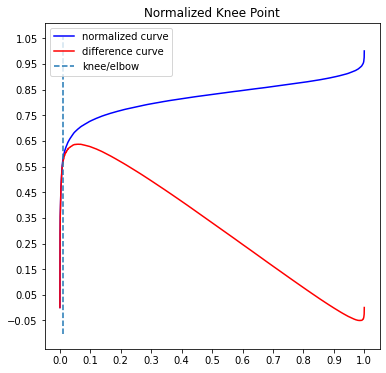

In [40]:
kneedle.plot_knee_normalized()

In [42]:
kneedle.knee_y

0.6857844190265147

### Mapper

In [14]:
projector = ensemble.IsolationForest(random_state=0, n_jobs=-1)
projector.fit(X)
lens1 = projector.decision_function(X)

In [15]:
mapper = km.KeplerMapper(verbose=3)
lens2 = mapper.fit_transform(X, projection = "knn_distance_10", scaler = None)

KeplerMapper(verbose=3)
..Composing projection pipeline of length 1:
	Projections: knn_distance_10
	Distance matrices: False
	Scalers: None
..Projecting on data shaped (60253, 16)

..Projecting data using: knn_distance_10


In [15]:
lens3 = mapper.fit_transform(X) # projection: sum

..Composing projection pipeline of length 1:
	Projections: sum
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (20231, 14)

..Projecting data using: sum

..Scaling with: MinMaxScaler()



In [16]:
pca = PCA(n_components = 1)
lens4 = pca.fit_transform(X)

In [16]:
lens5 = y

In [20]:
lens = np.c_[lens1, lens2, lens5]

In [21]:
G = mapper.map(
    lens,
    X,
    cover = km.Cover(n_cubes=20,
                     perc_overlap=.15),
    clusterer = DBSCAN(eps = 0.68))
    # clusterer = cluster.AgglomerativeClustering(5))

print(f"num nodes: {len(G['nodes'])}")
print(f"num edges: {sum([len(values) for key, values in G['links'].items()])}")

Mapping on data shaped (60253, 16) using lens shaped (60253, 3)

Minimal points in hypercube before clustering: 5
Creating 8000 hypercubes.
Cube_0 is empty.

Cube_1 is empty.

Cube_2 is empty.

Cube_3 is empty.

Cube_4 is empty.

Cube_5 is empty.

Cube_6 is empty.

Cube_7 is empty.

Cube_8 is empty.

Cube_9 is empty.

   > Found 0 clusters in hypercube 10.
Cube_11 is empty.

   > Found 0 clusters in hypercube 12.
Cube_13 is empty.

Cube_14 is empty.

   > Found 0 clusters in hypercube 15.
Cube_16 is empty.

Cube_17 is empty.

   > Found 0 clusters in hypercube 18.
Cube_19 is empty.

Cube_20 is empty.

Cube_21 is empty.

Cube_22 is empty.

Cube_23 is empty.

Cube_24 is empty.

Cube_25 is empty.

Cube_26 is empty.

Cube_27 is empty.

Cube_28 is empty.

Cube_29 is empty.

Cube_30 is empty.

Cube_31 is empty.

   > Found 0 clusters in hypercube 32.
Cube_33 is empty.

Cube_34 is empty.

Cube_35 is empty.

Cube_36 is empty.

   > Found 0 clusters in hypercube 37.
Cube_38 is empty.

Cube_39 i

In [22]:
_ = mapper.visualize(
    G,
    color_values = y,
    color_function_name= 'criticality',
    path_html = "mapper_y.html",
    X = X,
    X_names = rul_df.data_cols,
    lens = lens,
    lens_names = ["IsolationForest", "knn", "y"],
    title = "Mapper RUL"
)

Wrote visualization to: mapper_y.html
